Cluster Songs into Groups using unsupervised machine learning models.
Organize songs into 5 to 20 clusters based on their audio characteristics.
Your goal is to find natural groupings of songs that sound similar.

In [48]:
# import libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib.colors import LinearSegmentedColormap
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, adjusted_rand_score, normalized_mutual_info_score
from sklearn.impute import KNNImputer, SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import cluster, datasets
!pip install kneed
from kneed import KneeLocator
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
import pickle

In [50]:
# load 100 top Billboard songs dataset 
songs_billboard = "df_song_dict_billboard.csv"
df_songs_billboard = pd.read_csv(songs_billboard)
df_songs_billboard

,title,artist,rank
0,Luther,Kendrick Lamar & SZA,1
1,Die With A Smile,Lady Gaga & Bruno Mars,2
2,Not Like Us,Kendrick Lamar,3
3,TV Off,Kendrick Lamar Featuring Lefty Gunplay,4
4,A Bar Song (Tipsy),Shaboozey,5
...,...,...,...
95,No Pole,Don Toliver,96
96,Small Town Fame,Drake,97
97,Que Pasaria...,Rauw Alejandro & Bad Bunny,98
98,Greenlight,Tate McRae,99


Feature Selection from Audio Features Dataset

In [52]:
# load audio features dataset 
audio_features = "df_audio_features_clean.csv"
df_audio_features = pd.read_csv(audio_features)
df_audio_features

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90455,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5
90456,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4
90457,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4
90458,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4


In [54]:
# Summary of the data: checking data types
column_summary_df_audio_features = pd.DataFrame({
    'Column Name': df_audio_features.columns,
    'Data Type': df_audio_features.dtypes.values,
    'Non-Null Count': df_audio_features.notnull().sum().values,
    'Null Count': df_audio_features.isnull().sum().values,
    'Data Type': df_audio_features.dtypes.values,
    'Percentage Null': df_audio_features.isnull().mean().values * 100,
    'Unique Values': df_audio_features.nunique().values
})

print(column_summary_df_audio_features)

         Column Name Data Type  Non-Null Count  Null Count  Percentage Null  \
0           track_id    object           90460           0              0.0   
1            artists    object           90460           0              0.0   
2         album_name    object           90460           0              0.0   
3         track_name    object           90460           0              0.0   
4         popularity     int64           90460           0              0.0   
5        duration_ms     int64           90460           0              0.0   
6           explicit      bool           90460           0              0.0   
7       danceability   float64           90460           0              0.0   
8             energy   float64           90460           0              0.0   
9                key     int64           90460           0              0.0   
10          loudness   float64           90460           0              0.0   
11              mode     int64           90460      

In [60]:
# Selecting the columns with numerical features that shall be used for modelling:
df_audio_features_sel = df_audio_features.drop(columns=["track_id", "artists", "album_name", "track_name"])

In [62]:
# Chaning "explicit" column into 1 and 0
df_audio_features_sel["explicit"]=df_audio_features_sel["explicit"].astype(int)

In [64]:
df_audio_features_sel

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4
1,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4
2,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4
3,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3
4,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90455,21,384999,0,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5
90456,22,385000,0,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4
90457,22,271466,0,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4
90458,41,283893,0,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4


In [66]:
# Summary of the data: checking numerical distribution of data
df_audio_features_sel.describe()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,90460.000000,9.046000e+04,90460.000000,90460.000000,90460.000000,90460.000000,90460.000000,90460.000000,90460.000000,90460.000000,90460.000000,90460.000000,90460.000000,90460.000000,90460.000000
mean,33.232003,2.291321e+05,0.085751,0.562497,0.634824,5.284126,-8.490442,0.636900,0.087365,0.327650,0.172865,0.217087,0.469810,122.075536,3.897900
std,20.607727,1.127459e+05,0.279997,0.176554,0.256320,3.559823,5.209360,0.480896,0.113035,0.338027,0.323404,0.195045,0.262789,30.114972,0.452414
min,0.000000,8.586000e+03,0.000000,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,1.730455e+05,0.000000,0.450000,0.458000,2.000000,-10.312000,0.000000,0.036000,0.017100,0.000000,0.098200,0.250000,99.268750,4.000000
50%,33.000000,2.132930e+05,0.000000,0.576000,0.677000,5.000000,-7.182000,1.000000,0.048950,0.187000,0.000058,0.132000,0.458000,122.017000,4.000000
75%,49.000000,2.642400e+05,0.000000,0.692000,0.853000,8.000000,-5.107000,1.000000,0.085800,0.624000,0.095400,0.279000,0.683000,140.080000,4.000000
max,100.000000,5.237295e+06,1.000000,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


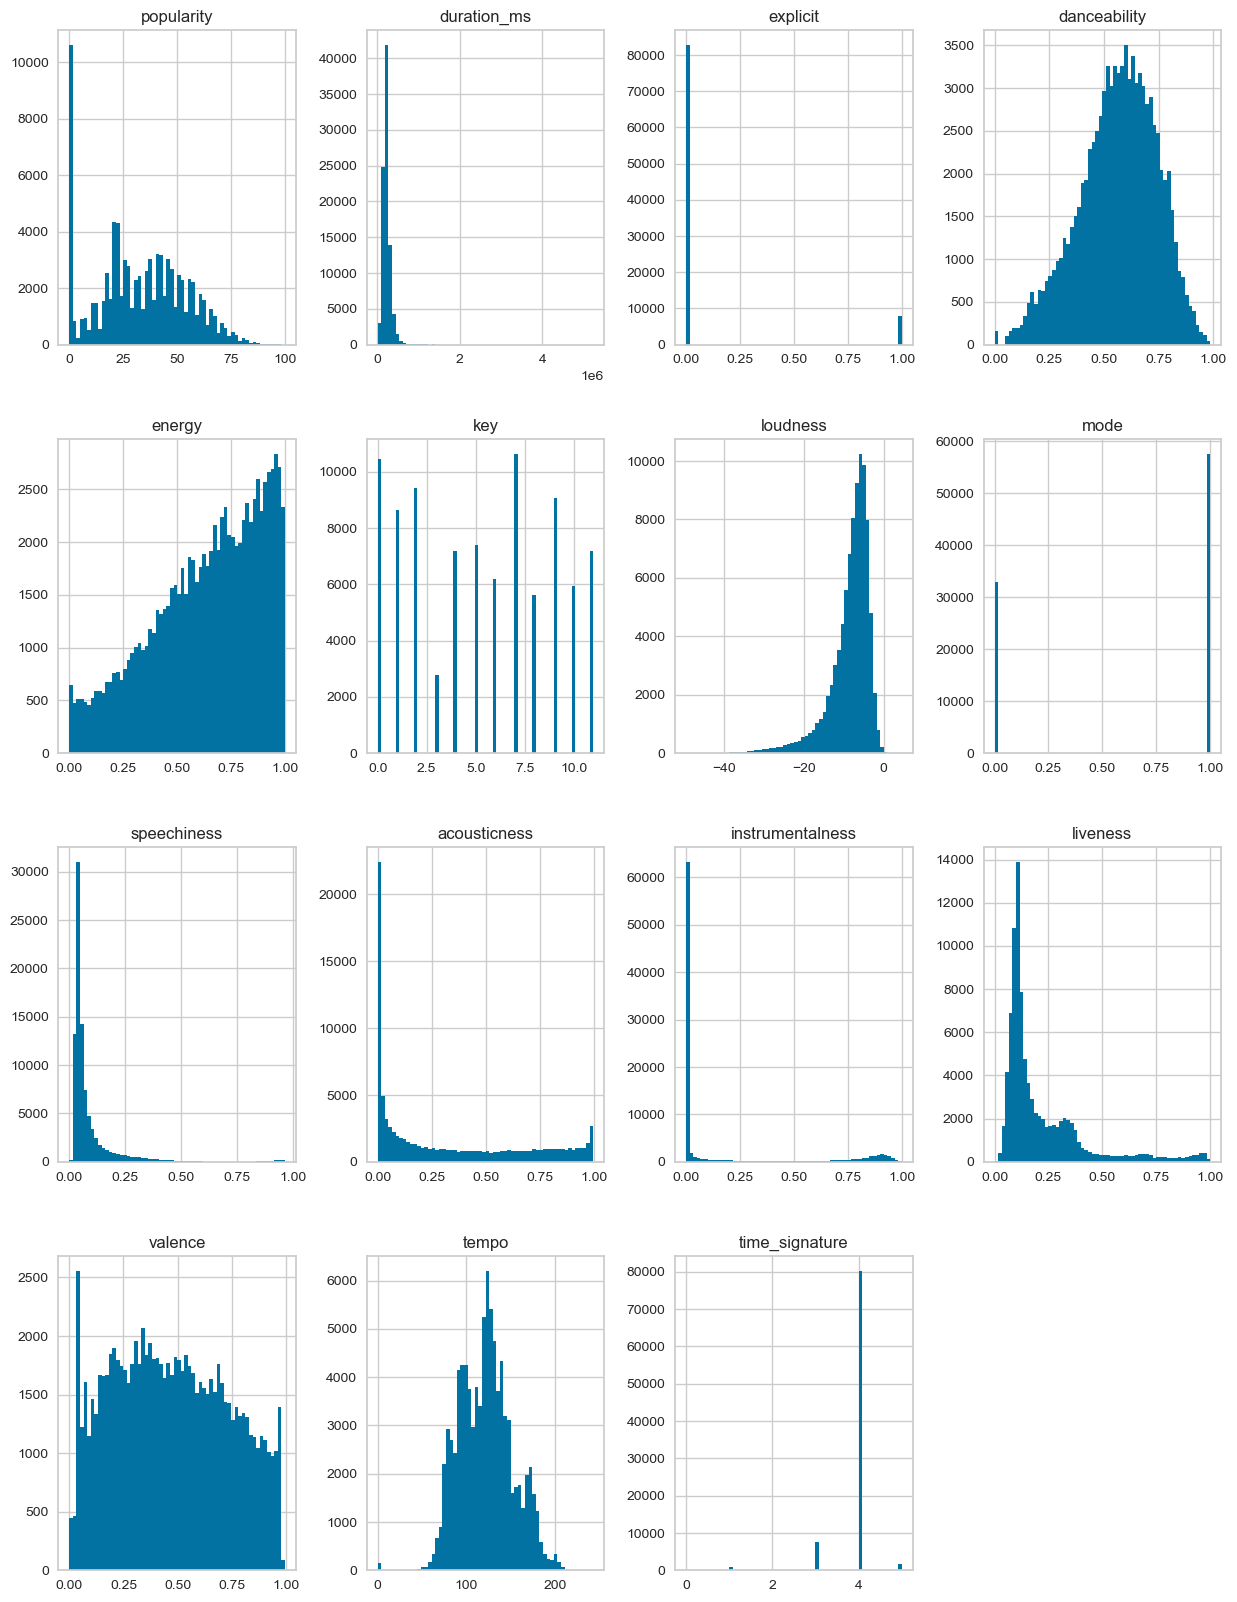

In [68]:
# Creating histograms for each numerical column in 'df_audio_features' to check for distribution
df_audio_features_sel.hist(figsize=(15, 20), bins=60, xlabelsize=10, ylabelsize=10);
plt.show()

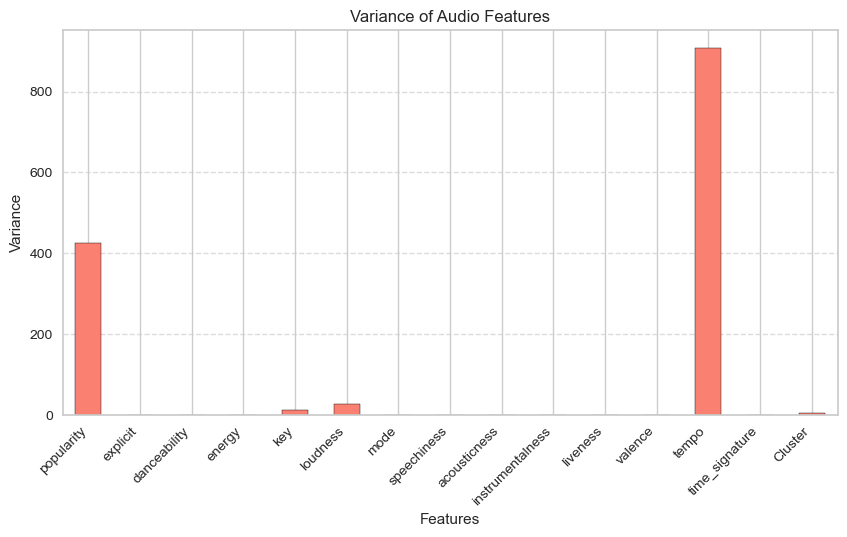

In [244]:
# Plotting the variance of all selected audio features.

# Drop "duration_ms" column, cause it has the the highest variance and makes the plot non-conclusive:
df_audio_features_sel_noDur=df_audio_features_sel.drop(columns=["duration_ms"])

# Compute the variance of all columns.
variances = df_audio_features_sel_noDur.var()

# Plot the variances.
plt.figure(figsize=(10, 5))
variances.plot(kind='bar', color='salmon', edgecolor='black')

# Labeling the plot
plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('Variance of Audio Features')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

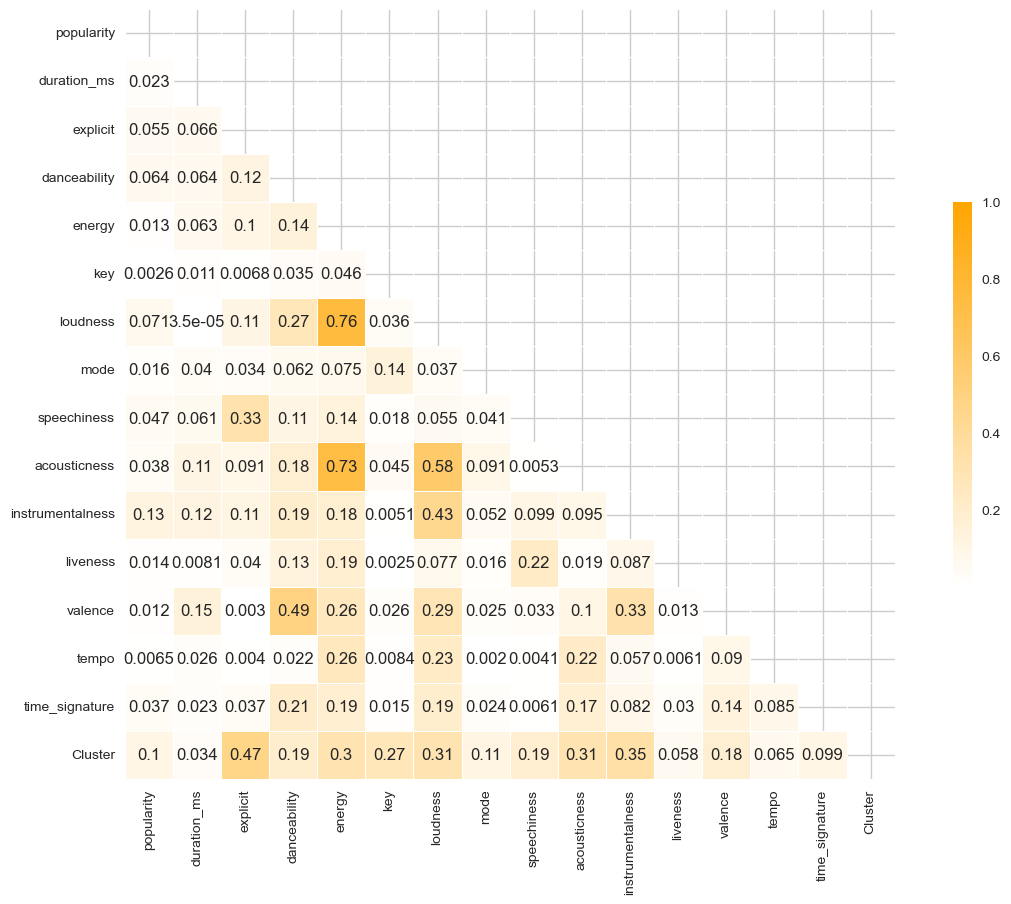

In [240]:
# Correlation analyis of the selected audio features.
# Generate a heatmap for visualization of correlation:

corr=np.abs(df_audio_features_sel.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Define a custom colormap from white to orange
colors = ["white", "orange"]
cmap = LinearSegmentedColormap.from_list("white_orange", colors)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot = True)

plt.show()

Preparation for modelling

In [74]:
# Normlization: MinMax Scaler for standardization: few outliers & no normal distribution
minmax = MinMaxScaler()
# fitting = calculating min and max for each column
minmax.fit(df_audio_features_sel)
# transforming = scaling the rest of the values in each column
audio_features_sel_norm = minmax.transform(df_audio_features_sel)
# The min max scaling returns an array instead of a dataframe
audio_features_sel_norm

array([[0.73      , 0.0424732 , 0.        , ..., 0.71859296, 0.36124534,
        0.8       ],
       [0.55      , 0.02697109, 0.        , ..., 0.26834171, 0.31839735,
        0.8       ],
       [0.57      , 0.03867876, 0.        , ..., 0.12060302, 0.31364331,
        0.8       ],
       ...,
       [0.22      , 0.05027627, 0.        , ..., 0.74673367, 0.54393274,
        0.8       ],
       [0.41      , 0.05265296, 0.        , ..., 0.41507538, 0.55865095,
        0.8       ],
       [0.22      , 0.04460757, 0.        , ..., 0.71155779, 0.32541952,
        0.8       ]])

In [76]:
# creating a dataframe of the X_train array again
df_audio_features_sel_norm = pd.DataFrame(audio_features_sel_norm, columns = df_audio_features_sel.columns)
df_audio_features_sel_norm.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0.73,0.042473,0.0,0.686294,0.4610,0.090909,0.791392,0.0,0.148187,0.032329,0.000001,0.3580,0.718593,0.361245,0.8
1,0.55,0.026971,0.0,0.426396,0.1660,0.090909,0.597377,1.0,0.079067,0.927711,0.000006,0.1010,0.268342,0.318397,0.8
2,0.57,0.038679,0.0,0.444670,0.3590,0.000000,0.736123,1.0,0.057720,0.210843,0.000000,0.1170,0.120603,0.313643,0.8
3,0.71,0.036978,0.0,0.270051,0.0596,0.000000,0.573701,1.0,0.037617,0.908635,0.000071,0.1320,0.143719,0.746758,0.6
4,0.82,0.036389,0.0,0.627411,0.4430,0.181818,0.737103,1.0,0.054508,0.470884,0.000000,0.0829,0.167839,0.492863,0.8


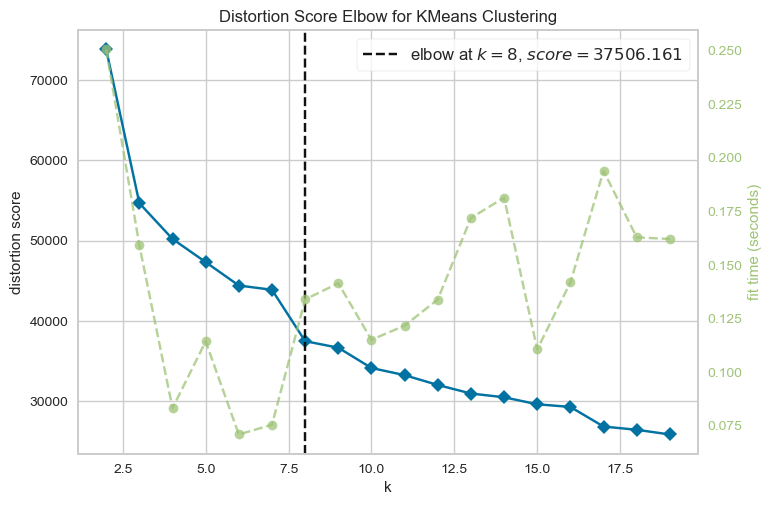

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [78]:
# Apply K-Means clustering to audio features
# Determine the elbow point = most suitable number of clusters !

model=cluster.KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(2,20))
visualizer.fit(df_audio_features_sel_norm)
visualizer.poof()

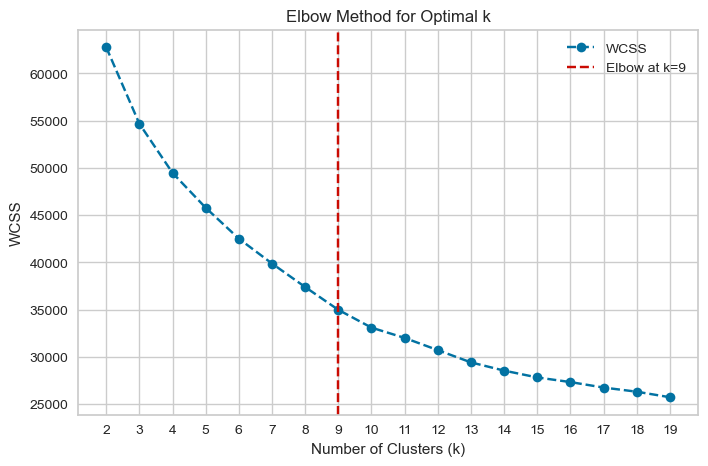

In [80]:
# Alternative method to determine the optimal number of clusters using the Elbow method.

# Define range of clusters
wcss = []  # Store Within-Cluster Sum of Squares
k_values = list(range(2, 20))  # Testing k from 2 to 19

# Iterate over a range of k values
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(df_audio_features_sel_norm)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS = Variance inside the cluster

# Find the optimal k using KneeLocator
knee_locator = KneeLocator(k_values, wcss, curve='convex', direction='decreasing')
optimal_k = knee_locator.elbow  # Get the elbow point

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--', color='b', label="WCSS")
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')  # Add vertical line
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

In [82]:
# Printing the calculated elbow point:
knee_locator = KneeLocator(k_values, wcss, curve='convex', direction='decreasing')
print(f"Optimal number of clusters: {knee_locator.elbow}")

Optimal number of clusters: 9


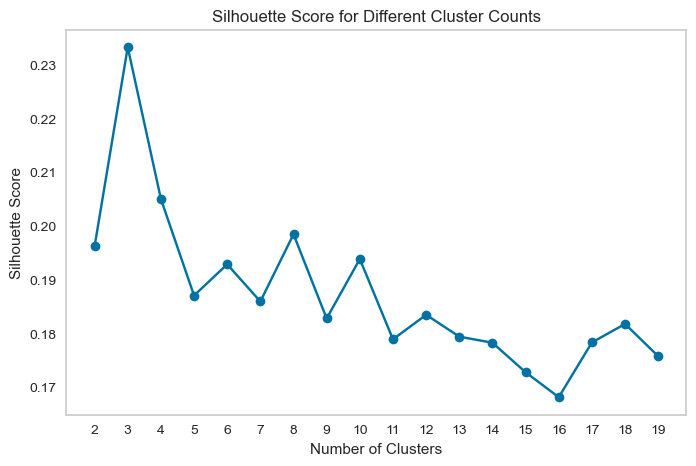

In [84]:
# Apply K-Means clustering to audio features
# Determine the most suitable number of clusters

cluster_range = range(2, 20)
silhouette_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(df_audio_features_sel_norm)
    # pickling --> put the files into a seperate folder named "pickles"
    filename = "pickles/kmeans_" + str(n_clusters) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
        
    score = silhouette_score(df_audio_features_sel_norm, cluster_labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Cluster Counts")
plt.xticks(cluster_range)
plt.grid()
plt.show()

In [134]:
# Apply KMeans clustering for the most suitable number of clusters = 8
kmeans8 = KMeans(n_clusters=8, random_state=0)
labels = kmeans8.fit_predict(df_audio_features_sel_norm)

# Compute the Silhouette Score for the most suitable number of clusters = 8
sil_score = silhouette_score(df_audio_features_sel_norm, labels)
print(f"Silhouette Score for 8 clusters when using Kmeans modelling: {sil_score}")

Silhouette Score for 8 clusters when using Kmeans modelling: 0.19845539323737646


In [136]:
kmeans8.cluster_centers_

array([[2.98237012e-01, 4.01103162e-02, 1.53704273e-03, 4.77826325e-01,
        3.13044063e-01, 4.81052455e-01, 6.53884614e-01, 3.66373598e-15,
        7.21191917e-02, 8.12254034e-01, 3.18027934e-01, 1.89234829e-01,
        3.27846207e-01, 4.57640528e-01, 7.48601291e-01],
       [2.64906224e-01, 5.04632630e-02, 1.42738589e-02, 5.50502146e-01,
        7.51708820e-01, 4.28879668e-01, 7.53018098e-01, 1.00000000e+00,
        7.79521768e-02, 9.26061131e-02, 7.88731950e-01, 2.06439436e-01,
        3.22483864e-01, 5.18442614e-01, 7.78024896e-01],
       [3.44988771e-01, 4.13584945e-02, 8.74300632e-16, 5.93098893e-01,
        7.26789698e-01, 7.20988712e-01, 7.96370584e-01, 1.00000000e+00,
        8.16888632e-02, 2.15437432e-01, 1.74659386e-02, 2.33643450e-01,
        5.67079998e-01, 5.17586459e-01, 7.89790217e-01],
       [3.07119353e-01, 3.89579557e-02, 1.22672824e-03, 4.72596928e-01,
        2.78384923e-01, 4.36308532e-01, 6.52472976e-01, 1.00000000e+00,
        6.07771796e-02, 8.33516674e-0

In [88]:
# load pickle files from seperate pickles folder

def load(filename = "filename.pickle"):
    try:
        with open("pickles/"+filename, "rb") as f:
            return pickle.load(f)

    except FileNotFoundError:
        print("File not found")

In [104]:
# Loading the pickles files with cluster allocation for n_clusters=8
kmeans8 = load("kmeans_8.pickle")
kmeans8

KMeans(random_state=0)

In [142]:
# Assigning the cluster ID to each song in the original audio features data frame
df_audio_features["Cluster"]=kmeans8.predict(df_audio_features_sel_norm)
df_audio_features

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Cluster
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,5
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,3
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,6
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,3
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90455,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,3
90456,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,0
90457,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,0
90458,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,2


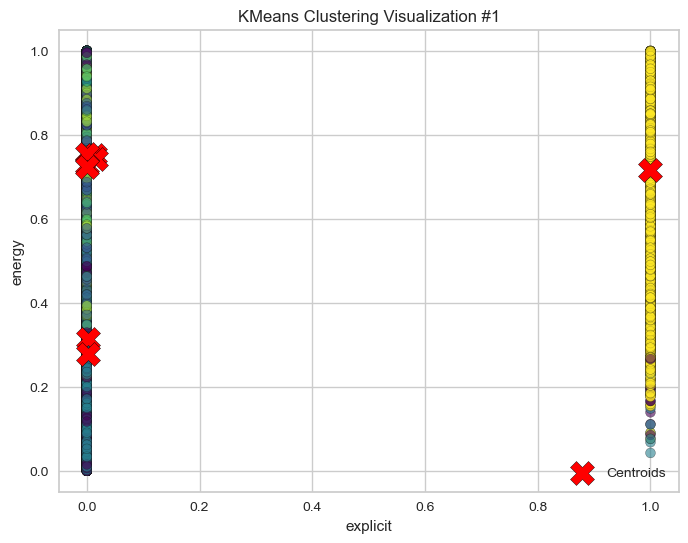

In [248]:
# Visualize the clusters using scatter plots.

plt.figure(figsize=(8, 6))
plt.scatter(df_audio_features_sel_norm.to_numpy()[:, 2], df_audio_features_sel_norm.to_numpy()[:, 4], c=labels, cmap='viridis', s=50, alpha=0.6, edgecolors='k')

# Plot the cluster centers
plt.scatter(kmeans8.cluster_centers_[:, 2], kmeans8.cluster_centers_[:, 4], 
            s=300, c='red', marker='X', edgecolors='black', label='Centroids')

# Labels and title
plt.xlabel('explicit')
plt.ylabel('energy')
plt.title('KMeans Clustering Visualization #1')
plt.legend()
plt.show()

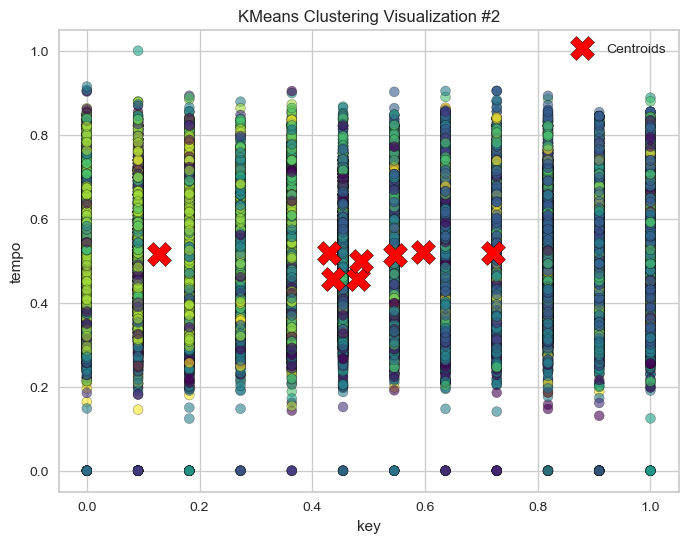

In [256]:
# Visualize the clusters using scatter plots.

plt.figure(figsize=(8, 6))
plt.scatter(df_audio_features_sel_norm.to_numpy()[:, 5], df_audio_features_sel_norm.to_numpy()[:, 13], c=labels, cmap='viridis', s=50, alpha=0.6, edgecolors='k')

# Plot the cluster centers
plt.scatter(kmeans8.cluster_centers_[:, 5], kmeans8.cluster_centers_[:, 13], 
            s=300, c='red', marker='X', edgecolors='black', label='Centroids')

# Labels and title
plt.xlabel('key')
plt.ylabel('tempo')
plt.title('KMeans Clustering Visualization #2')
plt.legend()
plt.show()

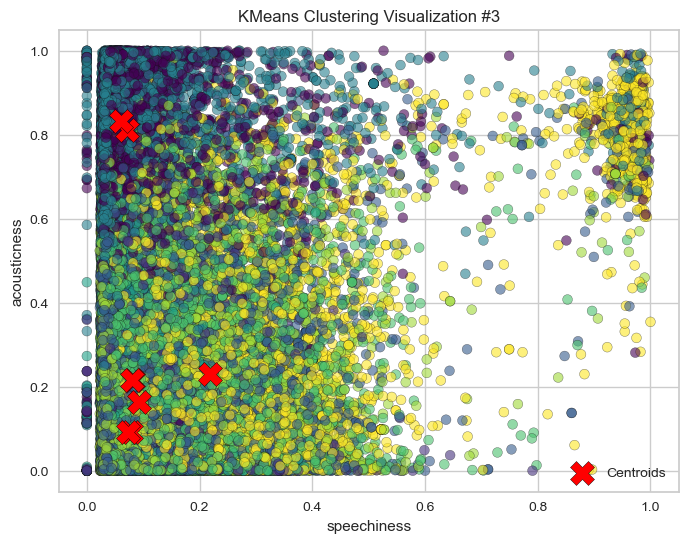

In [252]:
# Visualize the clusters using scatter plots.

plt.figure(figsize=(8, 6))
plt.scatter(df_audio_features_sel_norm.to_numpy()[:, 8], df_audio_features_sel_norm.to_numpy()[:, 9], c=labels, cmap='viridis', s=50, alpha=0.6, edgecolors='k')

# Plot the cluster centers
plt.scatter(kmeans8.cluster_centers_[:, 8], kmeans8.cluster_centers_[:, 9], 
            s=300, c='red', marker='X', edgecolors='black', label='Centroids')

# Labels and title
plt.xlabel('speechiness')
plt.ylabel('acousticness')
plt.title('KMeans Clustering Visualization #3')
plt.legend()
plt.show()

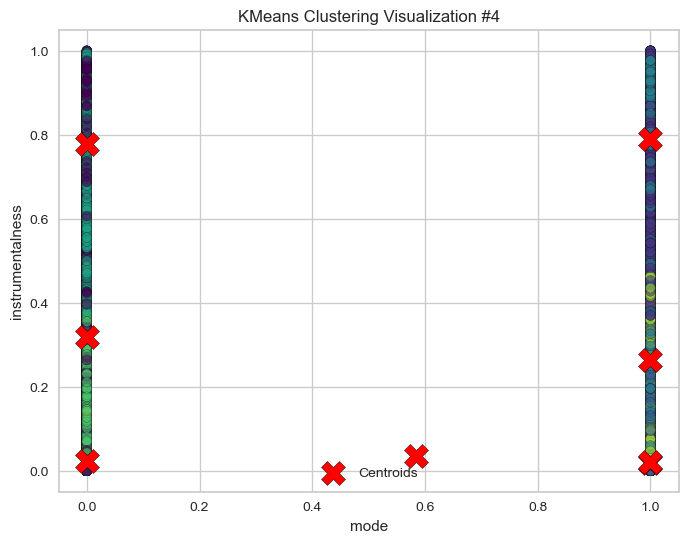

In [254]:
# Visualize the clusters using scatter plots.

plt.figure(figsize=(8, 6))
plt.scatter(df_audio_features_sel_norm.to_numpy()[:, 7], df_audio_features_sel_norm.to_numpy()[:, 10], c=labels, cmap='viridis', s=50, alpha=0.6, edgecolors='k')

# Plot the cluster centers
plt.scatter(kmeans8.cluster_centers_[:, 7], kmeans8.cluster_centers_[:, 10], 
            s=300, c='red', marker='X', edgecolors='black', label='Centroids')

# Labels and title
plt.xlabel('mode')
plt.ylabel('instrumentalness')
plt.title('KMeans Clustering Visualization #4')
plt.legend()
plt.show()

In [144]:
# Assigning the cluster ID to each song in the selected audio features data frame
df_audio_features_sel["Cluster"]=kmeans8.predict(df_audio_features_sel_norm)
df_audio_features_sel

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Cluster
0,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,5
1,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,3
2,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,6
3,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,3
4,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90455,21,384999,0,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,3
90456,22,385000,0,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,0
90457,22,271466,0,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,0
90458,41,283893,0,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,2


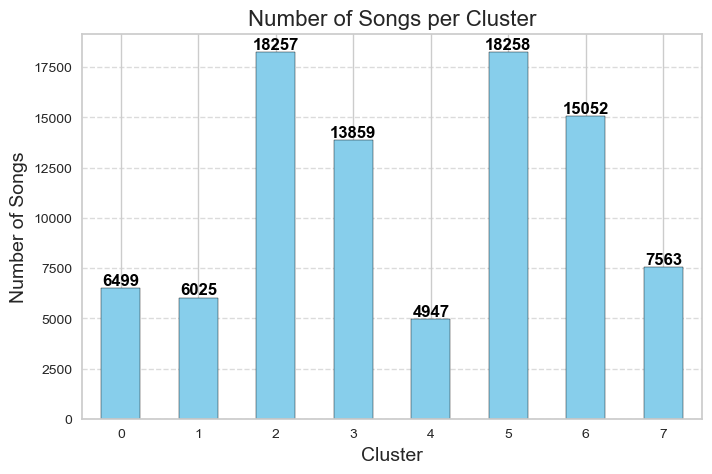

In [194]:
# Plotting the number of songs per cluster

# Count the number of songs in each cluster
cluster_counts = df_audio_features_sel['Cluster'].value_counts()

# Sort clusters in chronological order (assuming numerical clusters)
cluster_counts = cluster_counts.sort_index()

# Plot the bar chart
plt.figure(figsize=(8, 5))
bars=cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels on top of each bar
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position (center of bar)
        bar.get_height() + 1,  # Y position (slightly above the bar)
        str(int(bar.get_height())),  # Convert height (count) to string
        ha='center', va='bottom', fontsize=12, fontweight='bold', color='black'
    )

# Labeling the plot
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Number of Songs', fontsize=14)
plt.title('Number of Songs per Cluster', fontsize=16)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [196]:
# Checking the variance of feature columns inside clusters: popularity
df_audio_features_sel.groupby('Cluster')['popularity'].describe()
# Regarding "popularity" the clusters are not very different

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,6499.0,29.801508,20.370499,0.0,16.0,28.0,46.0,90.0
1,6025.0,26.491452,17.243769,0.0,13.0,22.0,41.0,86.0
2,18257.0,34.498877,20.569627,0.0,21.0,36.0,49.0,93.0
3,13859.0,30.710297,20.326949,0.0,18.0,29.0,47.0,94.0
4,4947.0,26.821710,17.507498,0.0,13.0,22.0,42.0,81.0
5,18258.0,36.136159,20.926889,0.0,21.0,37.0,52.0,98.0
6,15052.0,34.721100,20.287088,0.0,22.0,36.0,49.0,100.0
7,7563.0,37.330821,22.378220,0.0,22.0,38.0,55.0,98.0


In [198]:
# Checking the variance of feature columns inside clusters: danceability	
df_audio_features_sel.groupby('Cluster')['danceability'].describe()
# Regarding "danceability" the clusters are not very different

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,6499.0,0.470522,0.183012,0.0000,0.33900,0.484,0.610,0.962
1,6025.0,0.542255,0.213364,0.0000,0.38800,0.582,0.715,0.979
2,18257.0,0.584202,0.150326,0.0679,0.48600,0.591,0.692,0.984
3,13859.0,0.465503,0.174601,0.0000,0.34800,0.477,0.592,0.975
4,4947.0,0.566113,0.199794,0.0000,0.43700,0.604,0.723,0.983
5,18258.0,0.604002,0.154653,0.0916,0.50100,0.616,0.719,0.985
6,15052.0,0.583521,0.155428,0.0548,0.48375,0.586,0.693,0.981
7,7563.0,0.638597,0.169293,0.0647,0.52550,0.655,0.770,0.980


In [200]:
# Checking the variance of feature columns inside clusters: energy
df_audio_features_sel.groupby('Cluster')['energy'].describe()
# Regarding "energy" the clusters 0 and 3 are different - they have low energy.

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,6499.0,0.312734,0.179469,0.000000,0.174,0.308,0.439,1.000
1,6025.0,0.751823,0.216452,0.000020,0.612,0.818,0.933,1.000
2,18257.0,0.726790,0.174072,0.000020,0.598,0.743,0.875,1.000
3,13859.0,0.278384,0.157226,0.000019,0.157,0.278,0.388,1.000
4,4947.0,0.743175,0.204448,0.000020,0.601,0.786,0.922,1.000
5,18258.0,0.754362,0.159616,0.164000,0.644,0.776,0.887,0.999
6,15052.0,0.722323,0.175630,0.059100,0.591,0.737,0.872,1.000
7,7563.0,0.715963,0.186793,0.075900,0.577,0.723,0.878,1.000


In [202]:
# Checking the variance of feature columns inside clusters: speechiness
df_audio_features_sel.groupby('Cluster')['speechiness'].describe()
# Regarding "speechiness" the cluster 7 has very high speechiness.

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,6499.0,0.069617,0.108052,0.0000,0.0341,0.0415,0.05670,0.963
1,6025.0,0.075223,0.059612,0.0000,0.0410,0.0552,0.08470,0.763
2,18257.0,0.078830,0.088939,0.0223,0.0348,0.0479,0.08350,0.961
3,13859.0,0.058650,0.092293,0.0000,0.0321,0.0382,0.04930,0.962
4,4947.0,0.070375,0.052831,0.0000,0.0405,0.0529,0.07875,0.679
5,18258.0,0.089235,0.087262,0.0223,0.0393,0.0558,0.09890,0.950
6,15052.0,0.078060,0.089725,0.0221,0.0344,0.0474,0.07950,0.962
7,7563.0,0.210627,0.226713,0.0232,0.0618,0.1240,0.27000,0.965


In [204]:
# Checking the variance of feature columns inside clusters: acousticness
df_audio_features_sel.groupby('Cluster')['acousticness'].describe()
# Regarding "acousticness" the clusters 0 and 3 are different - they have high acousticness.

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,6499.0,0.809196,0.162490,0.000000,0.714000,0.84400,0.94550,0.996
1,6025.0,0.092148,0.172009,0.000000,0.000310,0.00619,0.09680,0.996
2,18257.0,0.214576,0.229322,0.000000,0.016700,0.12200,0.37100,0.987
3,13859.0,0.830161,0.139235,0.000000,0.748000,0.85600,0.94700,0.996
4,4947.0,0.090851,0.157205,0.000000,0.000625,0.00947,0.10500,0.843
5,18258.0,0.163634,0.192984,0.000001,0.009635,0.07760,0.26775,0.912
6,15052.0,0.214289,0.229648,0.000000,0.014900,0.12200,0.37900,0.986
7,7563.0,0.230037,0.270502,0.000000,0.011100,0.10700,0.37500,0.992


In [206]:
# Checking the variance of feature columns inside clusters: instrumentalness
df_audio_features_sel.groupby('Cluster')['instrumentalness'].describe()
# Regarding "instrumentalness" the clusters 1 and 4 are different - they have high instrumentalness.

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,6499.0,0.318300,0.402159,0.000,0.000004,0.006090,0.831000,1.000
1,6025.0,0.788719,0.147774,0.234,0.712000,0.837000,0.896000,1.000
2,18257.0,0.017466,0.064891,0.000,0.000000,0.000004,0.000541,0.664
3,13859.0,0.263491,0.388998,0.000,0.000000,0.000350,0.730000,1.000
4,4947.0,0.777774,0.156682,0.252,0.692000,0.832000,0.896000,1.000
5,18258.0,0.022722,0.068146,0.000,0.000000,0.000015,0.002260,0.586
6,15052.0,0.020843,0.072936,0.000,0.000000,0.000004,0.000668,0.741
7,7563.0,0.035679,0.130711,0.000,0.000000,0.000000,0.000332,0.950


In [208]:
# Checking the variance of feature columns inside clusters: liveness
df_audio_features_sel.groupby('Cluster')['liveness'].describe()
# Regarding "liveness" the clusters are not very different

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,6499.0,0.189139,0.174826,0.00000,0.0995,0.118,0.19300,0.987
1,6025.0,0.206488,0.182905,0.01370,0.0952,0.124,0.26700,0.994
2,18257.0,0.233643,0.208341,0.00986,0.0978,0.148,0.30600,1.000
3,13859.0,0.177776,0.159454,0.00000,0.1000,0.116,0.17600,0.990
4,4947.0,0.195138,0.174086,0.01120,0.0920,0.119,0.24650,0.985
5,18258.0,0.223699,0.195582,0.01140,0.0952,0.144,0.29975,0.993
6,15052.0,0.235583,0.208657,0.00925,0.0989,0.148,0.31100,1.000
7,7563.0,0.243198,0.214267,0.01960,0.1030,0.147,0.32100,0.992


In [210]:
# Checking the variance of feature columns inside clusters: valence
df_audio_features_sel.groupby('Cluster')['valence'].describe()
# Regarding "valence" the clusters 0,1,3 & 4 are rather sad, and the clusters 2,5,6 & 7 are rather cheerful.

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,6499.0,0.326033,0.231632,0.00000,0.1340,0.284,0.485,0.965
1,6025.0,0.320894,0.254590,0.00000,0.1070,0.253,0.483,0.988
2,18257.0,0.564245,0.245238,0.00001,0.3690,0.574,0.765,0.994
3,13859.0,0.338305,0.225724,0.00000,0.1600,0.300,0.484,0.983
4,4947.0,0.331738,0.252510,0.00000,0.1190,0.276,0.501,0.995
5,18258.0,0.540327,0.245537,0.00001,0.3470,0.545,0.743,0.988
6,15052.0,0.555720,0.248502,0.00771,0.3560,0.566,0.762,0.993
7,7563.0,0.474107,0.227544,0.02150,0.3005,0.473,0.648,0.989


In [212]:
# Checking the variance of feature columns inside clusters: tempo
df_audio_features_sel.groupby('Cluster')['tempo'].describe()
# Regarding "tempo" the clusters 0 and 3 are different - they have lower tempo.

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,6499.0,111.368261,31.348280,0.000,86.4020,109.9680,131.24900,220.084
1,6025.0,126.173908,28.599861,0.000,109.9830,125.0080,140.01900,219.693
2,18257.0,125.966052,29.436505,48.718,102.5180,125.0300,145.00800,220.081
3,13859.0,111.119960,31.680157,0.000,85.1495,109.9860,132.37250,222.605
4,4947.0,126.506429,26.447243,0.000,113.0880,125.0080,139.68100,243.372
5,18258.0,125.075374,28.450296,45.857,101.9980,123.9725,143.92500,216.558
6,15052.0,125.584141,28.715316,37.490,102.7800,124.8055,144.47375,215.149
7,7563.0,121.572543,30.675261,35.392,96.4385,119.9740,142.92750,213.778


In [216]:
# Checking the variance of feature columns inside clusters: key
df_audio_features_sel.groupby('Cluster')['key'].describe()
# Regarding "key" the cluster 6 is lowest, cluster 2 is highest.

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,6499.0,5.292814,3.468314,0.0,2.0,5.0,9.0,11.0
1,6025.0,4.717842,3.444454,0.0,1.0,5.0,7.0,11.0
2,18257.0,7.930876,1.801267,5.0,7.0,8.0,9.0,11.0
3,13859.0,4.799480,3.323078,0.0,2.0,5.0,7.0,11.0
4,4947.0,6.552658,3.460394,0.0,4.0,7.0,10.0,11.0
5,18258.0,6.011228,3.497608,0.0,4.0,6.0,9.0,11.0
6,15052.0,1.410710,1.332926,0.0,0.0,1.0,2.0,4.0
7,7563.0,5.350522,3.610165,0.0,2.0,6.0,8.5,11.0


In [220]:
# Checking the variance of feature columns inside clusters: explicit
df_audio_features_sel.groupby('Cluster')['explicit'].describe()
# Regarding "explicit" the cluster 7 is highest - very explicit; clusters 2, 5 & 6 are not explicit at all.

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,6499.0,0.001539,0.039199,0.0,0.0,0.0,0.0,1.0
1,6025.0,0.014440,0.119305,0.0,0.0,0.0,0.0,1.0
2,18257.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,13859.0,0.001227,0.035003,0.0,0.0,0.0,0.0,1.0
4,4947.0,0.016171,0.126147,0.0,0.0,0.0,0.0,1.0
5,18258.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
6,15052.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
7,7563.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [224]:
# Checking the variance of feature columns inside clusters: mode
df_audio_features_sel.groupby('Cluster')['mode'].describe()
# Regarding "mode" the clusters 1, 2, 3 & 6 are very melodic, clusters 0, 4 & 5 are not.

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,6499.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,6025.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,18257.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
3,13859.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
4,4947.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5,18258.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
6,15052.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
7,7563.0,0.584556,0.492831,0.0,0.0,1.0,1.0,1.0


In [228]:
# Checking the variance of feature columns inside clusters: loudness
df_audio_features_sel.groupby('Cluster')['loudness'].describe()
# Regarding "loudness" the clusters 0 & 3 are less loud.

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,6499.0,-14.186654,6.581881,-49.531,-17.53550,-12.5280,-9.4130,-1.977
1,6025.0,-8.817211,4.582734,-43.714,-10.88900,-8.1090,-5.6780,1.864
2,18257.0,-6.476817,2.764401,-29.911,-7.95600,-6.0540,-4.5580,1.343
3,13859.0,-14.257056,6.490796,-43.303,-17.15400,-12.5390,-9.6365,-0.689
4,4947.0,-8.676225,4.018095,-32.796,-10.71200,-8.1580,-5.9585,4.532
5,18258.0,-6.271191,2.687108,-26.570,-7.67675,-5.8835,-4.3990,1.700
6,15052.0,-6.610352,2.820855,-23.937,-8.15725,-6.1850,-4.6370,2.574
7,7563.0,-6.606791,3.159240,-24.843,-8.13350,-6.0760,-4.5040,1.821


In [232]:
# Checking the variance of feature columns inside clusters: time_signature
df_audio_features_sel.groupby('Cluster')['time_signature'].describe()
# Regarding "time_signature" (beats per bar) the clusters are not very different.

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,6499.0,3.742884,0.677129,0.0,4.0,4.0,4.0,5.0
1,6025.0,3.890124,0.526089,0.0,4.0,4.0,4.0,5.0
2,18257.0,3.948951,0.293109,0.0,4.0,4.0,4.0,5.0
3,13859.0,3.736778,0.681157,0.0,4.0,4.0,4.0,5.0
4,4947.0,3.919143,0.434942,0.0,4.0,4.0,4.0,5.0
5,18258.0,3.960510,0.282646,0.0,4.0,4.0,4.0,5.0
6,15052.0,3.942665,0.309906,1.0,4.0,4.0,4.0,5.0
7,7563.0,3.955177,0.420608,1.0,4.0,4.0,4.0,5.0


In [236]:
# Checking the variance of feature columns inside clusters: duration_ms
df_audio_features_sel.groupby('Cluster')['duration_ms'].describe()
# Regarding "duration_ms" the clusters are not very different.

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,6499.0,218303.600400,127566.558843,8586.0,154324.0,198554.0,257234.5,3876276.0
1,6025.0,272376.766639,151167.581704,24666.0,177320.0,252533.0,351333.0,4789026.0
2,18257.0,224837.532344,84104.085350,30209.0,179387.0,214986.0,256506.0,2959346.0
3,13859.0,212322.261419,119179.761536,13386.0,153333.0,195840.0,249106.5,4120258.0
4,4947.0,290705.953103,187693.997807,31333.0,195902.5,271952.0,367119.5,5237295.0
5,18258.0,231319.303812,87531.858450,30474.0,184283.5,218614.0,261959.0,4334721.0
6,15052.0,226810.891908,105767.112785,24266.0,178876.5,214233.0,258825.0,4339826.0
7,7563.0,204221.415972,87664.449974,31186.0,160268.0,193010.0,231964.5,4246206.0


In [172]:
# Filter the df_audio_features dataframe for rows where 'Cluster' is 0
df_audio_features_c0= df_audio_features[df_audio_features["Cluster"] == 0]
df_audio_features_c0.head(20)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Cluster
12,4ptDJbJl35d7gQfeNteBwp,Dan Berk,Solo,Solo,52,198712,False,0.489,0.3140,7,-9.245,0,0.0331,0.749,0.000000,0.1130,0.607,124.234,4,0
17,4Yo0igmcoNyat1secaH0OD,Andrew Foy;Renee Foy,At My Worst,At My Worst,54,169728,False,0.795,0.0841,10,-18.090,0,0.0461,0.742,0.000012,0.0853,0.609,91.803,4,0
25,6D33wCKzWtNEgOovgeVJ7r,Jason Mraz,Mellow Adult Pop,Bella Luna,1,302346,False,0.755,0.4540,9,-9.609,0,0.0352,0.757,0.000000,0.2360,0.330,120.060,4,0
36,62EwQLDw0dprDzuLwQ0sH1,KT Tunstall,Chill Christmas Dinner,Lonely This Christmas,0,257493,False,0.409,0.1530,6,-10.740,0,0.0306,0.939,0.000026,0.1080,0.180,85.262,4,0
39,0adVktNVJXPZfhQe6B1NO5,KT Tunstall,sadsadchristmas,Lonely This Christmas,0,257493,False,0.409,0.1530,6,-10.740,0,0.0306,0.939,0.000026,0.1080,0.180,85.262,4,0
41,1WFVfVjCtbmdIv7j3Fa9iy,Brandi Carlile,Mellow Adult Pop,When You're Wrong,0,266960,False,0.568,0.3010,10,-10.163,0,0.0373,0.796,0.000003,0.1180,0.142,88.029,4,0
50,72xTsTouZ5nBmASX8k1XCW,Highland Peak,Trampoline (Acoustic),Trampoline - Acoustic,46,213098,False,0.596,0.2000,0,-10.424,0,0.0305,0.910,0.000183,0.0884,0.308,107.893,4,0
54,2sYFi9xVSZ56WHKSY2fN1K,Adam Christopher,So Far Away (Acoustic),So Far Away - Acoustic,52,171543,False,0.576,0.3310,6,-9.389,0,0.0306,0.894,0.000034,0.1290,0.407,149.020,4,0
81,5IjTZ1g8KrIuV97N3OQZ0V,Gabrielle Aplin,Break Up Songs,The House We Never Built,0,195213,False,0.546,0.3910,2,-10.786,0,0.0630,0.784,0.000003,0.0552,0.202,139.669,4,0
82,3bHhUEOTIbezeZ856R0BX5,Eddie Vedder,Into The Wild (Music For The Motion Picture),Society,68,236306,False,0.561,0.3270,11,-10.835,0,0.0327,0.902,0.000469,0.1110,0.298,161.858,4,0


In [420]:
# Select a random song from cluster 0:
df_audio_features_c0.sample()[["track_id", "track_name", "artists"]]

,track_id,track_name,artists
26904,6Eeun5Lr7OofGeD5iWxUyx,Prologue,Seven Lions


In [422]:
# cluster "0" will be called "Slow & Melancholic Vibes" - slow songs, singer/songwriter, vocal, melancholic, ballads

In [174]:
# Filter the df_audio_features dataframe for rows where 'Cluster' is 1
df_audio_features_c1= df_audio_features[df_audio_features["Cluster"] == 1]
df_audio_features_c1.head(20)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Cluster
333,0avtLG17MT8kDf9xc67Niv,Rodrigo y Gabriela,Rodrigo Y Gabriela,Tamacun,50,205800,False,0.588,0.914,7,-7.442,1,0.0341,0.832000,0.856,0.1030,0.9710,128.553,4,1
526,5lQBkoXivgiXqKicR2uaTh,Masaharu Fukuyama,vs.2013 ~知覚と快楽の螺旋~,vs.2013 ~知覚と快楽の螺旋~,32,292493,False,0.403,0.925,9,-3.166,1,0.0537,0.000435,0.755,0.3230,0.5430,169.978,4,1
938,25R9Ax7cdjWx0EDr2HAKoA,AJJ,Christmas Island,Deathlessness,27,220832,False,0.554,0.655,11,-8.074,1,0.0388,0.001930,0.560,0.2800,0.3630,100.423,4,1
1049,5uCb2bQ9HcCY3c7kLq4Iur,Jackie Mittoo,The Keyboard King at Studio One,Darker Shade of Black,40,194293,False,0.689,0.564,6,-7.276,1,0.1260,0.149000,0.941,0.0909,0.7580,87.474,4,1
1051,2Y3x5VcEAxLNmVHxQOE0jB,Menahan Street Band,The Exciting Sounds of Menahan Street Band,Queens Highway,64,67720,False,0.778,0.399,1,-8.984,1,0.0858,0.075100,0.835,0.1030,0.3210,137.305,4,1
1074,2abpx1FO9dhMg16Q59iWL4,Criolo,Nó na Orelha,Samba Sambei (Dub Mix),32,220653,False,0.795,0.664,11,-10.679,1,0.0519,0.188000,0.890,0.1720,0.8540,136.029,4,1
1082,4YUWeLwUwRMzuxW5H4ASYp,BaianaSystem;As Ganhadeiras de Itapuã,Duas Cidades,Panela,33,173413,False,0.666,0.761,7,-5.472,1,0.0926,0.000143,0.712,0.1120,0.7970,143.035,4,1
1097,33NVGT7agcN1ems0OLUlCX,Manu Dibango,Best Afrodance Tunes,Dikalo - Remix 97,0,247626,False,0.784,0.869,2,-6.595,1,0.0369,0.010700,0.830,0.0422,0.6720,99.175,4,1
1099,14XaLZBDGnMY4313d4G51A,Ernest Ranglin,Best Afrodance Tunes,Stop That Train,3,336933,False,0.766,0.375,5,-13.456,1,0.0763,0.297000,0.862,0.1280,0.6200,81.626,4,1
1101,0FLmR0blAIztjE7YsQpoYc,El Michels Affair,Enter The 37th Chamber,Shimmy Shimmy Ya,49,145880,False,0.605,0.666,11,-5.770,1,0.0413,0.023400,0.647,0.0841,0.0865,100.138,4,1


In [400]:
# Select a random song from cluster 1:
df_audio_features_c1.sample()[["track_id", "track_name", "artists"]]

,track_id,track_name,artists
50361,1bilplPID1JKZxjOcEoUTY,Killing Fields,FGFC820


In [402]:
# cluster "1" will be called "Hard & Energetic" - rhythmical, rock/techno, little vocals, dancy, international, hard, instrumental

In [176]:
# Filter the df_audio_features dataframe for rows where 'Cluster' is 2
df_audio_features_c2= df_audio_features[df_audio_features["Cluster"] == 2]
df_audio_features_c2.head(20)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Cluster
5,01MVOl9KtVTNfFiBU9I7dc,Tyrone Wells,Days I Will Remember,Days I Will Remember,58,214240,False,0.688,0.481,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.666,98.017,4,2
7,1EzrEOXmMH3G43AXT1y7pA,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,80,242946,False,0.703,0.444,11,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.712,150.960,4,2
10,4mzP5mHkRvGxdhdGdAH7EJ,Zack Tabudlo,Episode,Give Me Your Forever,74,244800,False,0.627,0.363,8,-8.127,1,0.0291,0.2790,0.000000,0.0928,0.301,99.905,4,2
20,3S0OXQeoh0w6AY8WQVckRW,Jason Mraz,We Sing. We Dance. We Steal Things.,I'm Yours,75,242946,False,0.703,0.444,11,-9.331,1,0.0417,0.5590,0.000000,0.0973,0.712,150.960,4,2
32,1m5LC29RE52Bxy7hxvpOlL,Chord Overstreet,Christmas Country Songs 2022,All I Want For Christmas Is A Real Good Tan,0,234186,False,0.593,0.455,6,-8.192,1,0.0388,0.3660,0.000000,0.0914,0.564,202.019,4,2
40,6sp6Vx3sv2l5qxPfbQkcyt,Eddie Vedder,Mega Hits Autumn/Fall 2022,The Haves,0,306794,False,0.474,0.519,7,-5.291,1,0.0253,0.2810,0.000000,0.1070,0.326,151.832,4,2
44,6JGjevTaqr9J1xp7YvYUKF,Brandi Carlile,Finest Country,"Speak Your Mind (From the Netflix Series ""We T...",0,193943,False,0.476,0.666,6,-3.438,1,0.0446,0.3140,0.000000,0.3420,0.498,148.155,4,2
70,16dkWKIlBsfYTISCVuDs0w,Ron Pope,Whatever It Takes,A Drop In the Ocean,55,219480,False,0.484,0.573,5,-6.183,1,0.0298,0.0882,0.000001,0.1500,0.346,139.966,3,2
74,0Zf1BPkkFAWGtVHeBwHHz4,Ingrid Michaelson,It Doesn't Have To Make Sense,Light Me Up,56,247840,False,0.417,0.595,6,-7.840,1,0.0396,0.1580,0.000269,0.1010,0.117,147.928,4,2
76,2SkJKMfjpYsNv0KWOxiegX,A Great Big World,When the Morning Comes,Kaleidoscope,62,229320,False,0.709,0.913,7,-5.148,1,0.0748,0.0182,0.000000,0.1670,0.519,108.024,4,2


In [380]:
# Select a random song from cluster 2:
df_audio_features_c2.sample()[["track_id", "track_name", "artists"]]

,track_id,track_name,artists
70780,0grNELIxKngV6ozzbRZgQ5,Mariposas,Árbol


In [384]:
# cluster "2" will be called "Positive & Melodic Pop Vibes" - pop songs, vocal, cheesy, love songs, cheerful, highest key, melodic

In [178]:
# Filter the df_audio_features dataframe for rows where 'Cluster' is 3
df_audio_features_c3= df_audio_features[df_audio_features["Cluster"] == 3]
df_audio_features_c3.head(20)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Cluster
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.924,0.000006,0.1010,0.2670,77.489,4,3
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.905,0.000071,0.1320,0.1430,181.740,3,3
6,6Vc5wAMmXdKIAM7WUoEb7N,A Great Big World;Christina Aguilera,Is There Anybody Out There?,Say Something,74,229400,False,0.407,0.1470,2,-8.822,1,0.0355,0.857,0.000003,0.0913,0.0765,141.284,3,3
11,5ivF4eQBqJiVL5IAE9jRyl,Jason Mraz,Love Is a Four Letter Word,I Won't Give Up,69,240165,False,0.483,0.3030,4,-10.058,1,0.0429,0.694,0.000000,0.1150,0.1390,133.406,3,3
13,0X9MxHR1rTkEHDjp95F2OO,Anna Hamilton,Bad Liar,Bad Liar,62,248448,False,0.691,0.2340,3,-6.441,1,0.0285,0.777,0.000000,0.1200,0.2090,87.103,4,3
16,6xKeQgzfjixSUld14qUezm,Andrew Foy;Renee Foy,ily (i love you baby),ily (i love you baby),56,129750,False,0.706,0.1120,2,-18.098,1,0.0391,0.827,0.000004,0.1250,0.4140,110.154,4,3
19,6CgNoAbFJ4Q4Id4EjtbXlC,Boyce Avenue;Bea Miller,"Cover Sessions, Vol. 4",Photograph,67,260186,False,0.717,0.3200,3,-8.393,1,0.0283,0.830,0.000000,0.1070,0.3220,107.946,4,3
21,210JCw2LbYD4YIs8GiZ9iP,Boyce Avenue;Jennel Garcia,"Cover Sessions, Vol. 3",Demons,63,174174,False,0.678,0.3510,0,-8.654,1,0.0266,0.747,0.000000,0.3550,0.5690,90.032,4,3
22,5TvE3pk05pyFIGdSY9j4DJ,A Great Big World;Christina Aguilera,Is There Anybody Out There? - Track by Track C...,Say Something,70,229400,False,0.407,0.1470,2,-8.822,1,0.0355,0.857,0.000003,0.0913,0.0765,141.284,3,3
26,5IfCZDRXZrqZSm8AwE44PG,Jason Mraz,Holly Jolly Christmas,Winter Wonderland,0,131760,False,0.620,0.3090,5,-9.209,1,0.0495,0.788,0.000000,0.1460,0.6640,145.363,4,3


In [354]:
# Select a random song from cluster 3:
df_audio_features_c3.sample()[["track_id", "track_name", "artists"]]

,track_id,track_name,artists
80579,3rqMOGoQl7IFPe8AXk9vhf,The Infant King (Arr. D. Willcocks & G. Peders...,Traditional;The Norwegian Soloists' Choir;Gret...


In [362]:
# cluster "3" will be called "Acoustic & Melancholic Indipendent" - slower acoustic, melodic independent songs, vocal, rather melancholic

In [180]:
# Filter the df_audio_features dataframe for rows where 'Cluster' is 4
df_audio_features_c4= df_audio_features[df_audio_features["Cluster"] == 4]
df_audio_features_c4.head(20)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Cluster
552,3d8kYb3GqZkiHb6annxKEo,Andrew Belle,Nightshade,Swimmers,50,181093,False,0.547,0.599,11,-8.174,0,0.0301,0.003960,0.409,0.0847,0.0571,120.054,4,4
1060,3qdalnFVTJdRheIRZyuNmP,BaianaSystem;Buguinha Dub;Curumin;Edgar,Futuro Dub,Sonar (Adubado),34,174538,False,0.694,0.820,4,-7.885,0,0.0480,0.113000,0.897,0.1470,0.5880,99.922,4,4
1061,6SdaB4qWrwFG5goKg3NbVj,BaianaSystem,Forasteiro,Forasteiro,35,210373,False,0.685,0.732,9,-8.589,0,0.0322,0.005060,0.778,0.0640,0.8560,127.999,4,4
1062,3dCA1AG1JPlF848jihvVsE,Plastilina Mosh,Hola Chicuelos,Oxidados,35,148000,False,0.483,0.994,4,-6.676,0,0.0762,0.000444,0.765,0.0570,0.7020,182.051,4,4
1130,0eaOuJKKnxlUoQqgMnEait,Bixiga 70,Bixiga 70 (2011),Desengano da Vista,31,406573,False,0.535,0.644,0,-8.617,0,0.0442,0.543000,0.918,0.0939,0.7440,149.872,4,4
1139,74FgXyMVJm4muoRSZQRCVw,Orquestra Brasileira de Música Jamaicana,Volume I,O Guarani,32,221506,False,0.683,0.783,6,-7.155,0,0.0438,0.094100,0.840,0.1040,0.6340,141.940,4,4
1140,7COvgWy22fTEwQWcc5bBZd,Tony Allen,"Comet Series, Vol. 1 (Crazy Afrobeat)",Ikeja Roads,30,160948,False,0.777,0.598,2,-13.803,0,0.0412,0.023000,0.890,0.1060,0.6840,100.007,4,4
1154,3HQwAn3gDAfxTjXd93OhEv,Morbo y Mambo,Morbo y Mambo,gorila,27,162146,False,0.742,0.617,5,-10.134,0,0.0440,0.397000,0.888,0.1400,0.8470,101.999,4,4
1168,63nOQpjvgznL7lF5tEwsCs,Newen Afrobeat,Newen Afrobeat,Caminante,27,397573,False,0.604,0.904,6,-5.338,0,0.0483,0.078700,0.708,0.1440,0.5570,92.962,4,4
1170,7DGciw6JNzvNtdmvvANsHV,BaianaSystem,BaianaSystem,Barravenida,27,297360,False,0.646,0.651,7,-10.789,0,0.0328,0.002500,0.739,0.1700,0.6720,133.985,4,4


In [344]:
# Select a random song from cluster 4:
df_audio_features_c4.sample()[["track_id", "track_name", "artists"]]

,track_id,track_name,artists
10222,61Xo7rSNb8SPl7inRLSe4P,Alone - Save The Rave Remix,Guau;Save The Rave


In [358]:
# cluster "4" will be called "Energetic Beats" - jazzy/rocky/techno, faster tempo, no pop, rhythmical, little vocals, instrumental, energetic, not melodic

In [182]:
# Filter the df_audio_features dataframe for rows where 'Cluster' is 5
df_audio_features_c5= df_audio_features[df_audio_features["Cluster"] == 5]
df_audio_features_c5.head(20)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Cluster
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,1,-6.746,0,0.1430,0.03220,0.000001,0.3580,0.715,87.917,4,5
24,3Hn3LfhrQOaKihdCibJsTs,Jason Mraz,Human - Best Adult Pop Tunes,Unlonely,0,231266,False,0.796,0.667,5,-4.831,0,0.0392,0.38100,0.000000,0.2210,0.754,97.988,4,5
27,0dzKBptH2P5j5a0MifBMwM,Jason Mraz,Feeling Good - Adult Pop Favorites,If It Kills Me,0,273653,False,0.633,0.429,4,-6.784,0,0.0381,0.04440,0.000000,0.1320,0.520,143.793,4,5
52,2DHDuADAHoUW6n0z80RLQF,Andrew Belle,Black Bear,Pieces,60,241119,False,0.494,0.652,6,-5.863,0,0.0314,0.07540,0.002560,0.1250,0.298,137.018,4,5
61,6nXIYClvJAfi6ujLiKqEq8,Andrew Belle,The Daylight EP,Sky's Still Blue,62,244320,False,0.430,0.791,6,-5.419,0,0.0302,0.07260,0.019300,0.1100,0.217,171.864,4,5
79,7BXW1QCg56yzEBV8pW8pah,Jason Mraz,Know.,Have It All,65,226106,False,0.643,0.638,1,-4.947,0,0.0407,0.20400,0.000000,0.0707,0.600,82.001,4,5
80,2kMrCPZ0o5gErBPLCRgoli,Gabrielle Aplin,Mellow Adult Pop,Heavy Heart,0,235173,False,0.451,0.700,10,-6.597,0,0.0431,0.45500,0.002330,0.4050,0.370,150.055,4,5
86,6Uy6K3KdmUdAfelUp0SeXn,Sara Bareilles,The Blessed Unrest,Brave,70,220573,False,0.551,0.836,10,-3.838,0,0.0524,0.00502,0.000021,0.0425,0.758,185.063,4,5
98,7DYsBLdOqz0z14tYWMt2Tn,KT Tunstall,Del gusto de mamá,Hold On,0,177613,False,0.661,0.937,4,-5.157,0,0.0979,0.32200,0.000001,0.1900,0.805,105.549,4,5
114,6gijbGNDNNJgT60Aj7UCyc,Matthew Perryman Jones,Living in the Shadows,Living in the Shadows,53,212386,False,0.418,0.790,4,-6.599,0,0.0506,0.02840,0.000010,0.1170,0.197,175.975,4,5


In [320]:
# Select a random song from cluster 5:
df_audio_features_c5.sample()[["track_id", "track_name", "artists"]]

,track_id,track_name,artists
69408,3dDLEwHUOwLQ3Mdl6aNPt2,No Rest,Vicetone


In [360]:
# cluster "5" will be called "Cheerful & Energetic Dance" - dancy, vocals, cheerful, medium tempo, not really pop, rather electronic, not melodic, energetic, not explicit

In [184]:
# Filter the df_audio_features dataframe for rows where 'Cluster' is 6
df_audio_features_c6= df_audio_features[df_audio_features["Cluster"] == 6]
df_audio_features_c6.head(20)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Cluster
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.359,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,6
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.443,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,6
8,0IktbUcnAGrvD03AWnz3Q8,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,74,189613,False,0.625,0.414,0,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.669,130.088,4,6
9,7k9GuJYLp2AzqokyEdwEw2,Ross Copperman,Hunger,Hunger,56,205594,False,0.442,0.632,1,-6.770,1,0.0295,0.4260,0.004190,0.0735,0.196,78.899,4,6
14,4LbWtBkN82ZRhz9jqzgrb3,Chord Overstreet;Deepend,Hold On (Remix),Hold On - Remix,56,188133,False,0.755,0.780,2,-6.084,1,0.0327,0.1240,0.000028,0.1210,0.387,120.004,4,6
15,1KHdq8NK9QxnGjdXb55NiG,Landon Pigg,The Boy Who Never,Falling in Love at a Coffee Shop,58,244986,False,0.489,0.561,4,-7.933,1,0.0274,0.2000,0.000046,0.1790,0.238,83.457,3,6
18,2qLMf6TuEC3ruGJg4SMMN6,Jason Mraz;Colbie Caillat,We Sing. We Dance. We Steal Things.,Lucky,68,189613,False,0.625,0.414,0,-8.700,1,0.0369,0.2940,0.000000,0.1510,0.669,130.088,4,6
23,0BUuuEvNa5T4lMaewyiudB,Jason Mraz,Coffee Moment,93 Million Miles,0,216386,False,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,4,6
42,0e5PAxSyZ5DWWVqKANHETz,Brandi Carlile;Lucius,Country Car Hits,You and Me on the Rock,0,230098,False,0.568,0.686,1,-6.635,1,0.0330,0.1500,0.000002,0.0881,0.725,172.075,4,6
43,1MLr9b1fOybO3MGiLy47Ys,Brandi Carlile;Lucius,Country Road Songs,You and Me on the Rock,0,230098,False,0.568,0.686,1,-6.635,1,0.0330,0.1500,0.000002,0.0881,0.725,172.075,4,6


In [298]:
# Select a random song from cluster 6:
df_audio_features_c6.sample()[["track_id", "track_name", "artists"]]

,track_id,track_name,artists
77846,3zRCqQVCc73rfXPYvserdy,Voltadinha - Ao Vivo,Mariana Fagundes;Luíza & Maurílio


In [302]:
# cluster "6" will be called "Vocal & Melodic Indipendent" - vocals, no pop, medium tempo, rather happy, diverse, lowest key, melodic

In [186]:
# Filter the df_audio_features dataframe for rows where 'Cluster' is 7
df_audio_features_c7= df_audio_features[df_audio_features["Cluster"] == 7]
df_audio_features_c7.head(20)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Cluster
59,2gRKq9rIC5i1zuxp06zJWH,Chord Overstreet,What's Left of You,What's Left of You,57,178600,True,0.731,0.507,0,-6.477,1,0.0460,0.57200,0.000000,0.0912,0.265,117.969,4,7
243,3M6NL7PxIDZ3ArfPrBUTUP,Days N Daze,Show Me the Blueprints.,Flurry Rush,37,169318,True,0.371,0.674,9,-3.720,1,0.0488,0.16900,0.000000,0.0889,0.920,87.603,4,7
247,5DUAKXpyv3nL50PnAQbPS0,Get Dead,Tall Cans & Loose Ends,Fuck You,36,169266,True,0.608,0.917,11,-5.341,1,0.0601,0.23600,0.000000,0.1300,0.936,117.875,4,7
298,1MGIxsVtqK2npdPmI8Dj0D,Days N Daze,Rogue Taxidermy,Goodbye Lulu,35,150047,True,0.544,0.839,5,-8.991,1,0.0568,0.78400,0.000000,0.3410,0.967,87.609,4,7
399,42mkE3wbofBNickLHgdVlo,Get Dead,Dancing with the Curse,Stickup,32,223707,True,0.487,0.837,0,-5.865,1,0.0623,0.01330,0.000000,0.1020,0.207,160.025,4,7
446,0YG5wOXVpvNUyPihvr1zsa,Days N Daze;Freddie Boatright,Crustfall,To Risk to Live,32,122026,True,0.623,0.567,10,-7.779,1,0.0370,0.83100,0.000006,0.1040,0.929,129.949,4,7
489,353rT3h7ABEWWBe6Hr7EZD,Days N Daze,The Oogle Deathmachine,"Little Blue Pills, Pt. 2",31,265195,True,0.501,0.672,2,-10.225,0,0.0637,0.67400,0.000162,0.0674,0.961,122.041,4,7
491,5hhhrZMKz1NEZM7jRWufbf,Frank Turner,West Coast vs. Wessex,Bob,30,188952,True,0.415,0.713,0,-5.529,1,0.0345,0.05550,0.000000,0.0811,0.361,83.690,3,7
493,7EcFRiCKqijYsuA5UbNnQZ,Frank Turner,West Coast vs. Wessex,Perfect Government,30,146129,True,0.474,0.876,7,-5.052,1,0.0341,0.00277,0.000006,0.3900,0.607,91.948,4,7
494,4WbTMyywJtvUNhmVKa0oSM,The Bridge City Sinners,Unholy Hymns,The Fear,30,161205,True,0.444,0.674,5,-6.675,1,0.0341,0.58600,0.000147,0.1090,0.698,111.377,3,7


In [282]:
# Select a random song from cluster 7:
df_audio_features_c7.sample()[["track_id", "track_name", "artists"]]

,track_id,track_name,artists
29991,4s7U2mS26ab7GFtgeUcwKA,Ecstasy,XXXTENTACION;Noah Cyrus


In [300]:
# cluster "7" will be called "Explicit & Verbal" - independent/rock, vocal, faster, vocal, explicit, speechy, crazy, loud

In [424]:
# Label the Clusters (Genre & Mood-Based Categorization)

# Create a dictionary for cluster naming
cluster_mapping = {
    0: "Slow & Melancholic Vibes",
    1: "Hard & Energetic", 
    2: "Positive & Melodic Pop Vibes", 
    3: "Acoustic & Melancholic Indipendent", 
    4: "Energetic Beats", 
    5: "Cheerful & Energetic Dance",
    6: "Vocal & Melodic Indipendent", 
    7: "Explicit & Verbal", 
}

# Map the cluster names to the "Cluster" column in df_audio_features
df_audio_features['Cluster_Name'] = df_audio_features['Cluster'].map(cluster_mapping)

# Display the first few rows to verify:
print(df_audio_features[['Cluster', 'Cluster_Name']].head(30))

    Cluster                        Cluster_Name
0         5          Cheerful & Energetic Dance
1         3  Acoustic & Melancholic Indipendent
2         6         Vocal & Melodic Indipendent
3         3  Acoustic & Melancholic Indipendent
4         6         Vocal & Melodic Indipendent
5         2        Positive & Melodic Pop Vibes
6         3  Acoustic & Melancholic Indipendent
7         2        Positive & Melodic Pop Vibes
8         6         Vocal & Melodic Indipendent
9         6         Vocal & Melodic Indipendent
10        2        Positive & Melodic Pop Vibes
11        3  Acoustic & Melancholic Indipendent
12        0            Slow & Melancholic Vibes
13        3  Acoustic & Melancholic Indipendent
14        6         Vocal & Melodic Indipendent
15        6         Vocal & Melodic Indipendent
16        3  Acoustic & Melancholic Indipendent
17        0            Slow & Melancholic Vibes
18        6         Vocal & Melodic Indipendent
19        3  Acoustic & Melancholic Indi

In [426]:
# Safe the updated datafile for df_audio_features dataframe:
df_audio_features.to_csv("df_audio_features_all_clustered_kmeans8.csv", index=False)
# ONLY DONE ONCE !